In [1]:
import os.path as osp
import random
# 파일이나 텍스트에서 XML을 읽고, 가공하고 저장하기 위한 라이브러리
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
import torch.nn as nn
import json
import time
import torch.nn.functional as F

%matplotlib inline

## CH5.1 GAN을 활용한 화상 메커니즘과 DCGAN구현

### CH5.1.3 Generator 구현

In [2]:
class Generator(nn.Module):

  def __init__(self,z_dim = 20, image_size = 64):
    super(Generator, self).__init__()

    self.layer1 = nn.Sequential(
        nn.ConvTranspose2d(z_dim, image_size*8, kernel_size = 4, stride = 1),
        nn.BatchNorm2d(image_size * 8),
        nn.ReLU(inplace = True)
    )

    self.layer2 = nn.Sequential(
        nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size = 4 ,stride = 2, padding = 1),
        nn.BatchNorm2d(image_size * 4),
        nn.ReLU(inplace = True)
    )

    self.layer3 = nn.Sequential(
        nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size = 4 ,stride = 2, padding = 1),
        nn.BatchNorm2d(image_size * 2),
        nn.ReLU(inplace = True)
    )

    self.layer4 = nn.Sequential(
        nn.ConvTranspose2d(image_size * 2, image_size * 1, kernel_size = 4 ,stride = 2, padding = 1),
        nn.BatchNorm2d(image_size),
        nn.ReLU(inplace = True)
    )

    self.last = nn.Sequential(
        nn.ConvTranspose2d(image_size , 1, kernel_size = 4, stride = 2, padding = 1),
        nn.Tanh()
    )

  def forward(self,z):
    return self.last(self.layer4(self.layer3(self.layer2(self.layer1(z)))))

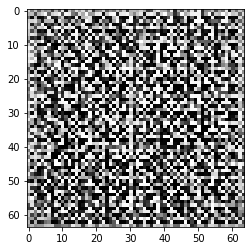

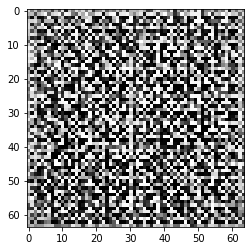

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]]]])


In [3]:
G = Generator(z_dim = 20, image_size = 64)

input_z = torch.randn(1,20)
input_z = input_z.view(input_z.size(0), input_z.size(1),1,1)
fake_images1 = G(input_z) 
fake_images2 = G.forward(input_z)

img_transformed1=fake_images1[0][0].detach().numpy()
img_transformed2=fake_images2[0][0].detach().numpy()
plt.imshow(img_transformed1, 'gray')
plt.show()
plt.imshow(img_transformed2, 'gray')
plt.show()
print( fake_images1 == fake_images2)

### CH5.1.5 Discrimiator 구현

In [4]:
class Discriminator(nn.Module):
  def __init__(self, z_dim = 20, image_size=64):
    super(Discriminator, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1,image_size, kernel_size = 4, stride = 2, padding = 1),
        nn.LeakyReLU(0.1, inplace = True)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(image_size ,image_size*2, kernel_size = 4, stride = 2, padding = 1),
        nn.LeakyReLU(0.1, inplace = True)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(image_size*2,image_size*4, kernel_size = 4, stride = 2, padding = 1),
        nn.LeakyReLU(0.1, inplace = True)
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d(image_size*4,image_size*8, kernel_size = 4, stride = 2, padding = 1),
        nn.LeakyReLU(0.1, inplace = True)
    )

    self.last = nn.Conv2d(image_size*8, 1, kernel_size = 4, stride = 1)

  def forward(self, z):
    return self.last(self.layer4(self.layer3(self.layer2(self.layer1(z)))))

In [5]:
from torchsummary import summary
model1 = Discriminator()
summary(model1,(1,64,64), batch_size = 10)
print("\n\n\n---------------------<절취선>---------------------\n\n\n")
model2 = Generator()
summary(model2,(20,1,1), batch_size = 10)

RuntimeError: ignored

In [6]:
d_out = model1(fake_images1)
print(nn.Sigmoid()(d_out))

tensor([[[[0.5040]]]], grad_fn=<SigmoidBackward0>)


##CH5.2 DCGAN의 손실함수, 학습, 생성

In [7]:
# 라벨 작성
mini_batch_size = 2
label_real = torch.full((mini_batch_size,),1)
label_fake = torch.full((mini_batch_size,),0) # torch.full((size), number)
criterion = nn.BCEWithLogitsLoss(reduction = 'mean') # 오차함수
D = Discriminator()
G = Generator()
d_out_real = D(x) #이미지 x가 가짜인지, 진짜인지 판정 일단 x가 생성이 안 되어 있어서 오류 발생.

input_z = torch.rann(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images) #생성된 이미지 G(z)가 가짜인지, 진짜인지 판정

# Discrimiation 의 오차함수 구현
# 평범한 Binary Cross Entropy이다. 
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)


# Generator의 오차함수 이미지 구현
# Generator는 label이 0일때만 학습 된다.
# -log(D(G(z))) 에 대해서 학습한다.
# G(z)가 D를 속이면 D(G(z))는 1이 된다. 즉 잘 속인 경우에는 -log(D(G(z)))가 이 되어 학습이 이루어지지 않는다
# G(z)가 D를 속이는데 실패하면 D(G(z))는 0이 되어 -log(D(G(z)))는 무한히 큰 양수가 되어 G의 학습이 이루어진다.
# D는 평범한 binary cross entropy로 '거짓' '진실' 이진분류를 수행한다. 
g_loss = criterion(d_out_fake.view(-1), label_real) # 원래는 label fake넣어야 맞는건데, -log(D(G(z)))를 최대화 시키기 위하여 라벨값을 거꾸로 준다.

NameError: ignored

###CH5.2.2 데이터 로더 작성

In [8]:
cd /content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/5_gan_generation

/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/5_gan_generation


In [9]:
from torchvision import transforms

def train_datapath_list():
  """학습 및 검증 데이터와 어노테이션 데이터의 파일 경로 리스트 작성"""
  train_img_list = list()

  for img_idx in range(200):
    img_path = "/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/5_gan_generation/data/img_78/img_7_" + str(img_idx)+ ".jpg"
    train_img_list.append(img_path)
    img_path = "/content/drive/MyDrive/만들면서_배우는_파이토치_딥러닝/5_gan_generation/data/img_78/img_8_" + str(img_idx)+ ".jpg"
    train_img_list.append(img_path)

  return train_img_list

class ImageTransform():
  """화상의 전처리 클래스"""
  def __init__(self,mean,std):
    self.data_transform = transforms.Compose([
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean,std)
    ])

  def __call__(self,img):
    return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
  def __init__(self, file_list, transform):
    self.file_list = file_list
    self.transform = transform

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self,index):
    """전처리한 이미지의 텐서 형식 데이터 취득"""
    img = Image.open(self.file_list[index])
    return self.transform(img)

In [10]:
train_list = train_datapath_list()

transform = ImageTransform(mean = 0.5, std = 0.5)

#데이터셋 정의
train_dataset = GAN_Img_Dataset(file_list = train_list, transform = transform)

# 데이터로더 정의
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

In [11]:
# 데이터로더 확인
iterator = iter(train_dataloader)
dummy = next(iterator)
dummy.size()

torch.Size([64, 1, 64, 64])

### CH5.2.3 DCGAN학습

In [12]:
def weight_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1: ## 문자열 내에서 파라미터를 못찾은 경우이다. 
    nn.init.normal_(m.weight.data, 0., 0.02)
    nn.init.constant_(m.bias, 0)
  elif classname.find("BatchNorm") != -1:
    nn.init.normal_(m.weight.data, 1., 0.02)
    nn.init.constant_(m.bias.data,0)

G.apply(weight_init)
D.apply(weight_init)
print("가중치 초기화 완료")

가중치 초기화 완료


In [13]:
def train_model(G,D, dataloader,num_epoch):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("Current device :",device)
  g_lr = 0.0001
  d_lr = 0.0004
  betas = [0.,0.9]
  # 최적화 알고리즘과 로스 펑션 설정
  g_optimizer = torch.optim.Adam(G.parameters(), lr = g_lr, betas = betas)
  d_optimizer = torch.optim.Adam(D.parameters(), lr = d_lr, betas = betas)
  criterion=nn.BCEWithLogitsLoss(reduction = 'mean')

  z_dim = 20 # 초기 잡음의 크기
  mini_batch_size = 64 # 배치사이즈

  G.to(device)
  D.to(device)
  G.train()
  D.train()

  torch.backends.cudnn.benchmark = True
  num_train_imgs = train_dataset.__len__()
  
  #카운터 설정
  iteration = 1
  logs = []

  for epoch in range(num_epoch):
    t_epoch_start = time.time()
    epoch_g_loss = 0.
    epoch_d_loss = 0.
    print("---------------------------------")
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    print("---------------------------------")
    print("<학습중>")

    for imges in dataloader:
      # D학습시키기.
      if imges.size()[0] == 1 :
        continue
      imges = imges.to(device)
      # 라벨 생성
      mini_batch_size = imges.size()[0]
      label_real = torch.full((mini_batch_size,),1.).to(device)
      label_fake = torch.full((mini_batch_size,),0.).to(device)

      # 진짜 화상의 판정 결과
      d_out_real = D(imges)

      # 가짜 화상 판정 결과
      input_z = torch.randn(mini_batch_size, z_dim).to(device)
      input_z = input_z.view(mini_batch_size, input_z.size(1), 1, 1)
      fake_images = G(input_z)
      d_out_fake = D(fake_images)

      # D 오차 계산
      d_loss_real = criterion(d_out_real.view(-1), label_real)
      d_loss_fake = criterion(d_out_fake.view(-1), label_fake) # 문제발생
      d_loss = d_loss_real + d_loss_fake
      

      # D 오차 역전파
      # g_optimzier.zero_gard()가 왜 필요한가?
      # g_optimizer.zero_grad()
      d_optimizer.zero_grad()

      d_loss.backward()
      d_optimizer.step()

      # G학습
      input_z = torch.randn(imges.size()[0], z_dim).to(device)
      input_z = input_z.view(imges.size()[0], input_z.size(1), 1, 1)
      fake_images = G(input_z)
      d_out_fake = D(fake_images) # 새로운 가짜 이미지를 만들어준다. 과적합 방지
      g_loss = criterion(d_out_fake.view(-1), label_real)

      # G오차 역전파
      # d_optimizer.zero_grad() # 이거 왜 필요함?
      # d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      
      g_loss.backward()
      g_optimizer.step()
      # g_optimizer.step() 이거는 왜 제외해야 할까?

      epoch_d_loss += d_loss.item()
      epoch_g_loss += g_loss.item()
      iteration += 1

    t_epoch_finish = time.time()
    print("---------------------------------")
    print("epoch {} || D_Loss : {:.4f} || G_Loss : {:.4f}".format(epoch+1, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
    print("timer: {:.4f} sec".format(t_epoch_finish - t_epoch_start))

    t_epoch_start = time.time()
  return G, D

In [14]:
num_epochs = 200
G = Generator()
D = Discriminator()
G_update, D_update = train_model(G,D,dataloader=train_dataloader, num_epoch = num_epochs)

Current device : cuda:0
---------------------------------
Epoch 1/200
---------------------------------
<학습중>
---------------------------------
epoch 1 || D_Loss : 0.1729 || G_Loss : 0.2168
timer: 106.0946 sec
---------------------------------
Epoch 2/200
---------------------------------
<학습중>
---------------------------------
epoch 2 || D_Loss : 0.0271 || G_Loss : 0.3815
timer: 0.7561 sec
---------------------------------
Epoch 3/200
---------------------------------
<학습중>
---------------------------------
epoch 3 || D_Loss : 0.2962 || G_Loss : 0.5807
timer: 0.7624 sec
---------------------------------
Epoch 4/200
---------------------------------
<학습중>
---------------------------------
epoch 4 || D_Loss : 0.0131 || G_Loss : 0.3618
timer: 0.7674 sec
---------------------------------
Epoch 5/200
---------------------------------
<학습중>
---------------------------------
epoch 5 || D_Loss : 0.0023 || G_Loss : 0.5455
timer: 0.7493 sec
---------------------------------
Epoch 6/200
--------

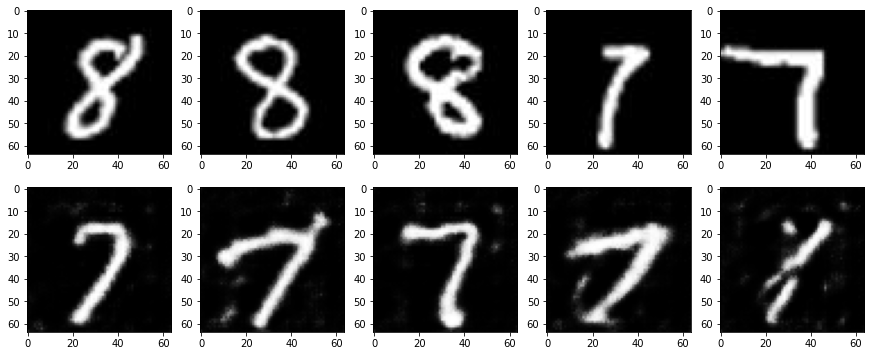

In [15]:
# 생성 화상과 훈련 데이터를 시각화한다
# 이 셀은 괜찮은 느낌의 화상이 생성될 때까지, 몇 번을 재실행하고 있습니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 화상 생성
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다


# 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

##CH5.3 Self Attention GAN의 개요 

###CH5.3.2 Self Attention 도입

In [65]:
X = torch.randn((1,1,64,64)) # BCHW
X = X.view(X.shape[0], X.shape[1], X.shape[2]*X.shape[3] ) #BCN
X_T = X.permute(0,2,1) #BNC
S = torch.bmm(X_T,X) # S.size = (channel (dim = 0, -3), width*height (dim = 1, -2), width*height(dim = 2, -1))
m = nn.Softmax(dim = -2) # H 축/열에 대해 정규화
attention_map_T = m(S) # 전치되어 있는 attention map
attention_map = attention_map_T.permute(0,2,1) # W축에 대해 정규화 되어있는 어텐션 맵

# Self attention map 계산
o = torch.bmm(X, attention_map.permute(0,2,1)) # H축에 대해 정규화 되어 있는 어텐션 맵을 x와 곱함으로써, 어텐션 효과 발생
o2 = torch.bmm(X, attention_map_T) # 근데 왜 굳이 이런 쓸데없는 transpose가 많을까?

assert (o==o2).sum() == 4096 

In [51]:
a = torch.rand((1,1,2,3)).view(1,1,6) # 배치, 채널 ,행, 렬
b = a.transpose(1,2).matmul(a) # 대칭행렬
b 

# 파이토치에서는 
# 1차원 (행)
# 2차원 (열, 행)
# 3차원 (채널, 열 , 행)
# 4차원 (배치, 채널, 열, 행)

m1 = nn.Softmax(dim = 0) # 3차원 -> 채널수직방향으로 softmax -> 다 1로 나옴
m2 = nn.Softmax(dim = 1) # 3차원 -> 열 방향으로 softmax 
m3 = nn.Softmax(dim = 2) # 3차원 -> 행 방향으로 softmax

m4 = nn.Softmax(dim = -1) # 3차원 -> 행 방향으로 softmax
m5 = nn.Softmax(dim = -2) # 3차원 -> 열 방향으로 softmax 
m6 = nn.Softmax(dim = -3) # 3차원 -> 채널수직방향으로 softmax -> 다 1로 나옴

print(m1(b),'\n')
print(m2(b),'\n')
print(m3(b),'\n')
print(m4(b),'\n')
print(m5(b),'\n')
print(m6(b),'\n')

tensor([[[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]]]) 

tensor([[[0.1796, 0.1816, 0.1728, 0.1732, 0.1773, 0.1815],
         [0.2064, 0.2153, 0.1831, 0.1844, 0.1976, 0.2149],
         [0.1249, 0.1165, 0.1485, 0.1471, 0.1336, 0.1168],
         [0.1275, 0.1195, 0.1498, 0.1485, 0.1358, 0.1199],
         [0.1566, 0.1536, 0.1632, 0.1629, 0.1593, 0.1537],
         [0.2051, 0.2136, 0.1826, 0.1839, 0.1966, 0.2132]]]) 

tensor([[[0.1796, 0.2064, 0.1249, 0.1275, 0.1566, 0.2051],
         [0.1816, 0.2153, 0.1165, 0.1195, 0.1536, 0.2136],
         [0.1728, 0.1831, 0.1485, 0.1498, 0.1632, 0.1826],
         [0.1732, 0.1844, 0.1471, 0.1485, 0.1629, 0.1839],
         [0.1773, 0.1976, 0.1336, 0.1358, 0.1593, 0.1966],
         [0.1815, 0.2149, 0.1168, 0.1199, 0.1537, 0.2132]]]) 

tensor([[[0.1796, 0.2064, 0.1249, 0.1275, 0.1566, 0.2051],
         [0

###CH5.3.4 스펙트럴 정규화

In [68]:
# 립시츠 연속성을 만족시키기 위하여 
image_size = 64
nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8 , kernel_size = 4, stride = 1))

ConvTranspose2d(20, 512, kernel_size=(4, 4), stride=(1, 1))

## CH5.4 Self-Attention GAN의 학습 및 생성

###CH5.4.1 Self-Attention GAN의 학습과 생성

In [94]:
class Self_Attention(nn.Module):
  """Self Attention Layer"""

  def __init__(self, in_dim):
    super(Self_Attention, self).__init__()
    # 11conv는 PCA와 같은 이미지이다. 
    # 입력 데이터의 어떠한 셀의 특징량을 계산할 때 주목할 주위 셀은 자신과 값이 비슷한 셀로 한다.는 제한에 잘 작동하는 특징량으로
    # 입력데이터를 변환하기 위하여
    # 계산을 줄이기 위하여
    self.query_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim//8, kernel_size = 1) # 11 conv
    self.key_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim//8, kernel_size = 1) # 11 conv
    self.value_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim, kernel_size = 1) # 11 conv

    # 곱해질 때 정규화를 위한 소프트맥스
    self.softmax = nn.Softmax(dim = -2) # 열 방향으로의 정규화

    # 어텐션의 학습가능한 가중치. 처음에는 0으로 둔다.
    self.gamma = nn.Parameter(torch.zeros(1))

  def forward(self,x):
    X = x

    # B C' W H -> B C' N
    proj_query = self.query_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3]) 
    proj_query = proj_query.permute(0,2,1) # B N C' 
    proj_key = self.key_conv(X).view(X.shape[0], -1, X.shape[2]*X.shape[3]) # B C' N
    S = torch.bmm(proj_query, proj_key) # B N N
    attention_map_T = self.softmax(S) # B N(정규화됨) N
    attention_map = attention_map_T.permute(0,2,1) # B N N(정규화됨)

    proj_value = self.value_conv(X).view(X.shape[0], -1 , X.shape[2]*X.shape[3]) # B C N
    
    # self attention 결과
    o = torch.bmm(proj_value, attention_map.permute(0,2,1)) # (B C N) * (B N N ) = (B C N)
    o = o.view(X.shape[0],X.shape[1], X.shape[2], X.shape[3] ) # (B C N) -> (B C H W)
    out = x+self.gamma*o
    return out, attention_map

 

### CH5.4.2 생성기 Generator 구현

In [114]:
class Generator(nn.Module) :
  def __init__(self, z_dim = 20, image_size = 64):
    super(Generator, self).__init__()

    self.layer1 = nn.Sequential(
        nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size = 4, stride = 1)),
        nn.BatchNorm2d(image_size * 8),
        nn.ReLU(inplace = True)
    )
    self.layer2 = nn.Sequential(
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(image_size * 4),
        nn.ReLU(inplace = True)
    )
    self.layer3 = nn.Sequential(
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(image_size * 2),
        nn.ReLU(inplace = True)
    )
    

    self.self_attention1 = Self_Attention(image_size * 2)

    self.layer4 = nn.Sequential(
        nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 2, image_size * 1, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(image_size * 1),
        nn.ReLU(inplace = True)
    )

    self.self_attention2 = Self_Attention(image_size * 1)

    self.last = nn.Sequential(nn.ConvTranspose2d(image_size, 1, kernel_size =4, stride = 2, padding = 1), nn.Tanh())

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out, attention_map1 = self.self_attention1(out)
    out = self.layer4(out)
    out, attention_map2 = self.self_attention2(out)
    out = self.last(out)
    return out, attention_map1, attention_map2


### CH5.4.3 식별기 Discriminator 구현

In [90]:
class Discriminator(nn.Module):
  def __init__(self, z_dim = 20, image_size = 64):
    super(Discriminator, self).__init__()

    self.layer1 = nn.Sequential(
        nn.utils.spectral_norm(nn.Conv2d(1, image_size, kernel_size = 4, stride = 2, padding = 1)),
        nn.LeakyReLU(0.1, inplace = True)
    )

    self.layer2 = nn.Sequential(
        nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, kernel_size = 4, stride = 2, padding = 1)),
        nn.LeakyReLU(0.1, inplace = True)
    )

    self.layer3 = nn.Sequential(
        nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size = 4, stride = 2, padding = 1)),
        nn.LeakyReLU(0.1, inplace = True)
    )

    self.self_attention1 = Self_Attention(image_size * 4)

    self.layer4 = nn.Sequential(
        nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size = 4, stride = 2, padding = 1)),
        nn.LeakyReLU(0.1, inplace = True)
    )

    self.self_attention2 = Self_Attention(image_size * 8)

    self.last = nn.Conv2d(image_size*8, 1, kernel_size = 4, stride = 1)
    

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out, attention_map1 = self.self_attention1(out)
    out = self.layer4(out)
    out, attention_map2 = self.self_attention2(out)
    out = self.last(out)
    return out, attention_map1, attention_map2


###CH5.4.5 네트워크 초기화와 학습 실시

In [159]:
def train_model(G,D, dataloader,num_epoch):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("Current device :",device)
  g_lr = 0.0001
  d_lr = 0.0004
  betas = [0.,0.9]
  # 최적화 알고리즘과 로스 펑션 설정
  g_optimizer = torch.optim.Adam(G.parameters(), lr = g_lr, betas = betas)
  d_optimizer = torch.optim.Adam(D.parameters(), lr = d_lr, betas = betas)
  # criterion=nn.BCEWithLogitsLoss(reduction = 'mean')

  z_dim = 20 # 초기 잡음의 크기
  mini_batch_size = 64 # 배치사이즈

  G.to(device)
  D.to(device)
  G.train()
  D.train()

  torch.backends.cudnn.benchmark = True
  num_train_imgs = train_dataset.__len__()
  batch_size = dataloader.batch_size
  #카운터 설정
  iteration = 1
  logs = []

  for epoch in range(num_epoch):
    t_epoch_start = time.time()
    epoch_g_loss = 0.
    epoch_d_loss = 0.
    print("---------------------------------")
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    print("---------------------------------")
    print("<학습중>")

    for imges in dataloader:
      # D학습시키기.
      if imges.size()[0] == 1 :
        continue
      imges = imges.to(device)
      # 라벨 생성은 없어도 된다. 
      mini_batch_size = imges.size()[0]
      #label_real = torch.full((mini_batch_size,),1.).to(device)
      #label_fake = torch.full((mini_batch_size,),0.).to(device)
      
      # 진짜 화상의 판정 결과
      d_out_real,_,_ = D(imges)

      # 가짜 화상 판정 결과
      input_z = torch.randn(mini_batch_size, z_dim).to(device)
      input_z = input_z.view(mini_batch_size, input_z.size(1), 1, 1)
      fake_images,_,_ = G(input_z)
      d_out_fake,_,_ = D(fake_images)

      # D 오차 계산
      d_loss_real = torch.nn.ReLU()(1.-d_out_real).mean()
      d_loss_fake = torch.nn.ReLU()(1.+d_out_fake).mean()
      d_loss = d_loss_real + d_loss_fake
      # 힌지 형태의 D loss

      # D 오차 역전파
      # g_optimzier.zero_gard()가 왜 필요한가?
      # g_optimizer.zero_grad()
      d_optimizer.zero_grad()

      d_loss.backward()
      d_optimizer.step()

      # G학습
      input_z = torch.randn(imges.size()[0], z_dim).to(device)
      input_z = input_z.view(imges.size()[0], input_z.size(1), 1, 1)
      fake_images,_,_ = G(input_z)
      d_out_fake,_,_ = D(fake_images) # 새로운 가짜 이미지를 만들어준다. 과적합 방지
      g_loss = -d_out_fake.mean()
      # 힌지 형태의 G loss

      # G오차 역전파
      # d_optimizer.zero_grad() # 이거 왜 필요함?
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      
      g_loss.backward()
      g_optimizer.step()
      # g_optimizer.step() 이거는 왜 제외해야 할까?

      epoch_d_loss += d_loss.item()
      epoch_g_loss += g_loss.item()
      iteration += 1

    t_epoch_finish = time.time()
    print("---------------------------------")
    print("epoch {} || D_Loss : {:.4f} || G_Loss : {:.4f}".format(epoch+1, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
    print("timer: {:.4f} sec".format(t_epoch_finish - t_epoch_start))

    t_epoch_start = time.time()
  return G, D

In [160]:
def weight_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1: ## 문자열 내에서 파라미터를 못찾은 경우이다. 
    nn.init.normal_(m.weight.data, 0., 0.02)
    nn.init.constant_(m.bias, 0)
  elif classname.find("BatchNorm") != -1:
    nn.init.normal_(m.weight.data, 1., 0.02)
    nn.init.constant_(m.bias.data,0)



가중치 초기화 완료


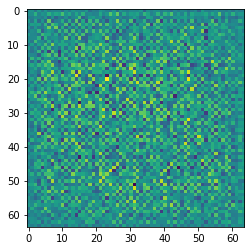

Dummy classification :  0.05133098363876343


In [161]:
num_epochs = 300
G = Generator()
D = Discriminator()
G.apply(weight_init)
D.apply(weight_init)
print("가중치 초기화 완료")
dummy = G(torch.randn((1,20,1,1)))[0]
plt.imshow(dummy.detach().view(64,64))
plt.show()
#dummy_img = torch.randn((1,1,64,64))
dummy_result = D(dummy)[0]
print("Dummy classification : ",dummy_result.item())

In [163]:
G_update, D_update = train_model(G,D,dataloader=train_dataloader, num_epoch = num_epochs)

Current device : cuda:0
---------------------------------
Epoch 1/300
---------------------------------
<학습중>
---------------------------------
epoch 1 || D_Loss : 0.0628 || G_Loss : 0.1981
timer: 1.1472 sec
---------------------------------
Epoch 2/300
---------------------------------
<학습중>
---------------------------------
epoch 2 || D_Loss : 0.0016 || G_Loss : 0.2454
timer: 1.1346 sec
---------------------------------
Epoch 3/300
---------------------------------
<학습중>
---------------------------------
epoch 3 || D_Loss : 0.0757 || G_Loss : 0.1185
timer: 1.1430 sec
---------------------------------
Epoch 4/300
---------------------------------
<학습중>
---------------------------------
epoch 4 || D_Loss : 0.0989 || G_Loss : 0.0428
timer: 1.1619 sec
---------------------------------
Epoch 5/300
---------------------------------
<학습중>
---------------------------------
epoch 5 || D_Loss : 0.0565 || G_Loss : 0.1033
timer: 1.1311 sec
---------------------------------
Epoch 6/300
----------

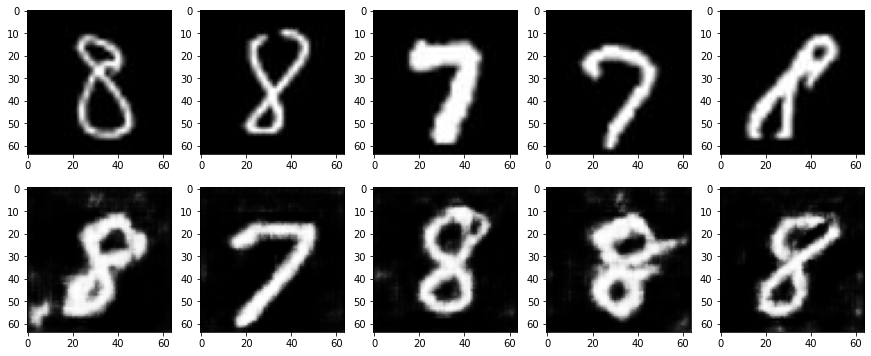

In [177]:
# 생성 화상과 훈련 데이터를 시각화한다
# 이 셀은 괜찮은 느낌의 화상이 생성될 때까지, 몇 번을 재실행하고 있습니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 화상 생성
G_update.eval()
fake_images, am1, am2 = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다


# 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

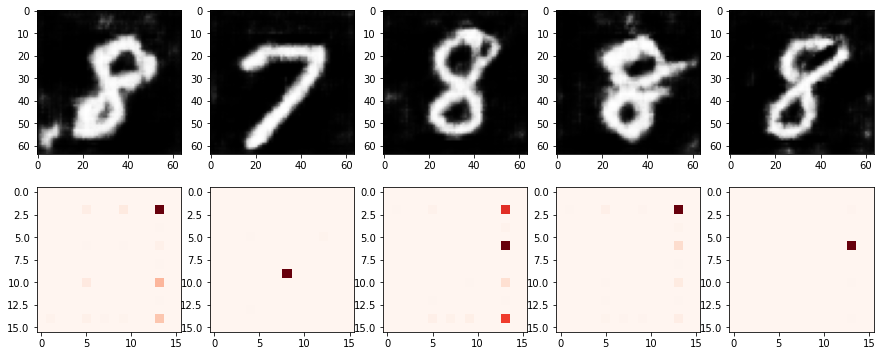

In [179]:
# Attentiom Map을 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):

    # 상단에 생성한 화상 데이터를 표시
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 Attention Map1 화상 중앙의 픽셀 데이터를 표시
    plt.subplot(2, 5, 5+i+1)
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7]  # 중앙에 주목
    plt.imshow(am.cpu().detach().numpy(), 'Reds')
